# Experiment 1: Learning the radius of a sphere
We will try to learn the radius of a sphere by using our differentiable renderer. We are going to try two different rendering modes (flat and phong shading), once with edge subsampling and without.

In [35]:
from collections import namedtuple
from IPython.display import display

import numpy as np


import matplotlib.pyplot as plt

import source.tensorize as t
import torch.optim as optim 
import torch.nn.functional as F
from source.scene import *
from source.renderer import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Ground Truth and Initial Guess

Remember the trainable quantities are the scene parameters.  

In [57]:
experiment = 'position_test_1'
true_scene = parse_scene('./scenes/%s.ground_truth.yaml' % experiment)
pred_scene = parse_scene('./scenes/%s.init1.yaml' % experiment)


Now create the images and display the initialization:

With subsampling - Albedo:


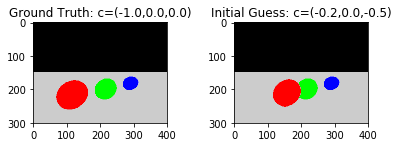

Without subsampling - Albedo:


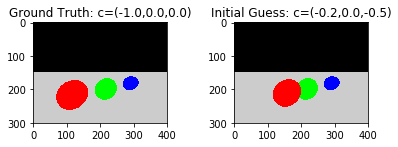

In [68]:
true_renderer = FlatRenderer(true_scene)
true_image_sub = true_renderer.forward()
true_image = true_renderer.forward(False)

pred_renderer = FlatRenderer(pred_scene)
pred_renderer.set_trainable({'ball_1': ['radius']})
pred_image_sub = pred_renderer.forward()
pred_image = pred_renderer.forward(False)
center = t.detach_numpy(pred_renderer.ball_1['center'])


print("With subsampling - Albedo:")
true_image_sub.show_image('albedo', title='Ground Truth: c=(%.1f,%.1f,%.1f)'% (true_scene['ball_1'].center[0], true_scene['ball_1'].center[1], true_scene['ball_1'].center[2]), subplot='121')
pred_image_sub.show_image('albedo', title='Initial Guess: c=(%.1f,%.1f,%.1f)'% (center[0], center[1], center[2]), subplot='122')
plt.subplots_adjust(wspace=0.5)
plt.show()


print("Without subsampling - Albedo:")
true_image.show_image('albedo', title='Ground Truth: c=(%.1f,%.1f,%.1f)'% (true_scene['ball_1'].center[0], true_scene['ball_1'].center[1], true_scene['ball_1'].center[2]), subplot='121')
pred_image.show_image('albedo', title='Initial Guess: c=(%.1f,%.1f,%.1f)'% (center[0], center[1], center[2]), subplot='122')
plt.subplots_adjust(wspace=0.5)
plt.show()


#### And now with Phong Shading

Phong Shaded image:


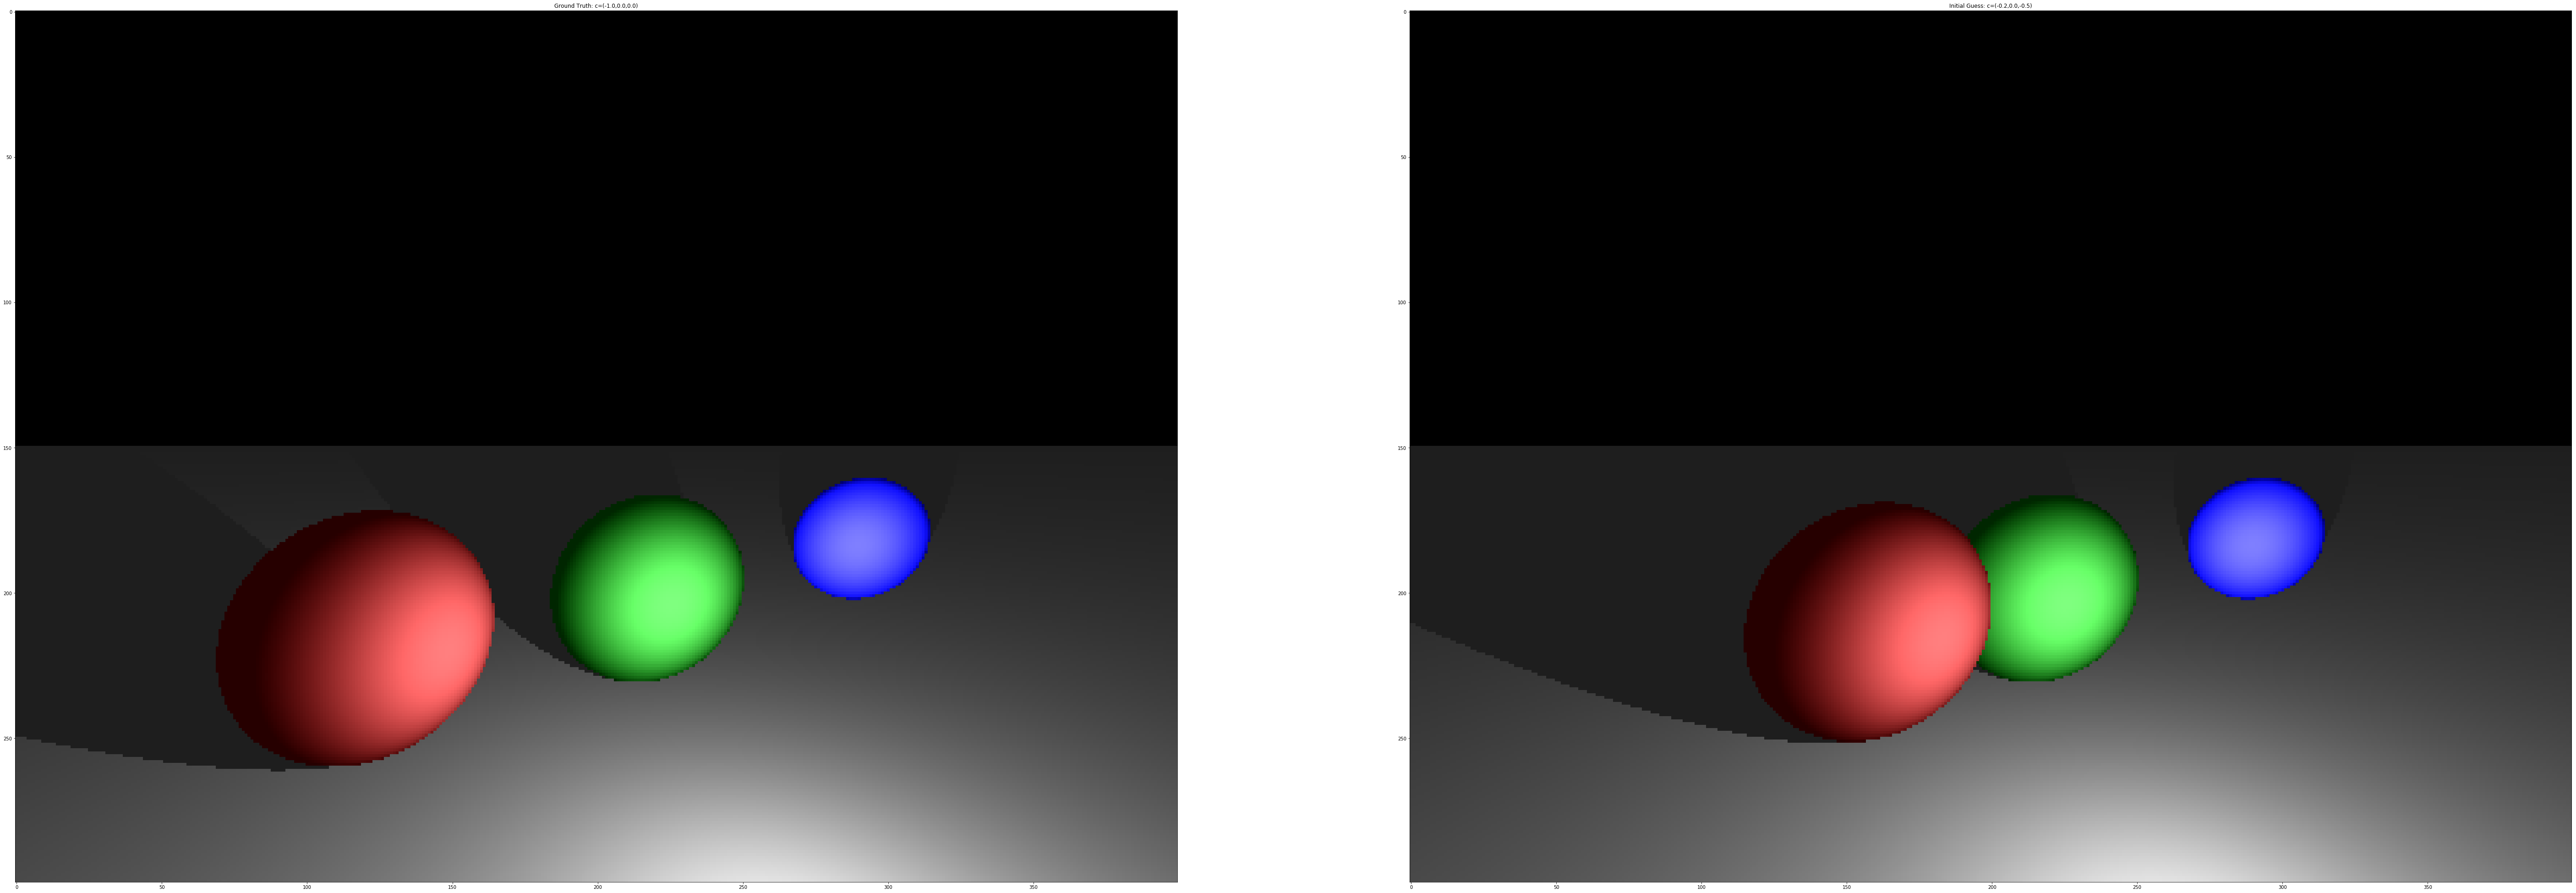

In [118]:
true_phong_renderer = PhongRenderer(true_scene)
true_phong_image_sub = true_phong_renderer.forward()
true_phong_image = true_phong_renderer.forward(False)

pred_phong_renderer = PhongRenderer(pred_scene)
pred_phong_image_sub = pred_phong_renderer.forward()
pred_phong_image = pred_phong_renderer.forward(False)
center = t.detach_numpy(pred_renderer.ball_1['center'])


print("Phong Shaded image:")
plt.figure(figsize=(100,100))
true_phong_image_sub.show_image('albedo', title='Ground Truth: c=(%.1f,%.1f,%.1f)'% (true_scene['ball_1'].center[0], true_scene['ball_1'].center[1], true_scene['ball_1'].center[2]), subplot='121')
pred_phong_image_sub.show_image('albedo', title='Initial Guess: c=(%.1f,%.1f,%.1f)'% (center[0], center[1], center[2]), subplot='122')
plt.show()



This function will train our renderers

In [125]:
def train(ground_truth, renderer, subsampling=False, image_type='depth', iterations = 500):
    suffix = "with subsampling" if subsampling else "without subsampling"
    print("Training a {0} regarding a {1} image ".format(pred_renderer.__class__.__name__, image_type) + suffix)
    loss_history = []
    
    renderer.set_trainable({'ball_1': ['center']})
    params  = filter(lambda p: p.requires_grad, renderer.parameters())
    optimizer = optim.Adam(params, lr=0.01)

    for _ in range(iterations):

        renderer.clear()
        optimizer.zero_grad()

        prediction = renderer.forward(subsampling)
        center = t.detach_numpy(renderer.ball_1['center'])
        loss = F.l1_loss(ground_truth.get_image(image_type), prediction.get_image(image_type))
        loss = loss
        loss.backward()
        optimizer.step()


        #history of intermediate losses and images 
        loss_history.append(t.detach_numpy(loss))

        if _ % (iterations/10)  == 0:
            ground_truth.show_image(image_type, title='Ground Truth: c=(%.1f,%.1f,%.1f)'% (true_scene['ball_1'].center[0], true_scene['ball_1'].center[1], true_scene['ball_1'].center[2]), subplot='121')
            prediction.show_image(image_type, title='Attempt %d: c=(%.1f,%.1f,%.1f)'% (_,center[0], center[1], center[2]), subplot='122')
            plt.subplots_adjust(wspace=0.5)
            plt.show()


    _ = np.arange(iterations)
    plt.plot(_, loss_history, label='loss')
    plt.xticks(np.arange(0,iterations+1,iterations//10))
    plt.legend()
    plt.show()


Now, let's try different trainings

Training a FlatRenderer regarding a albedo image without subsampling


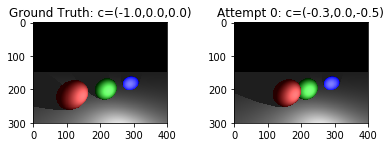

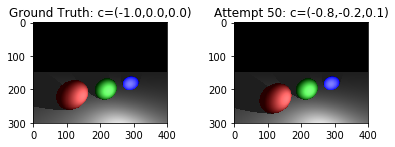

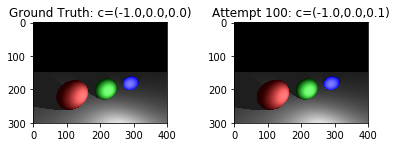

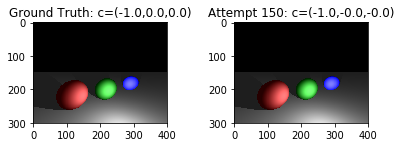

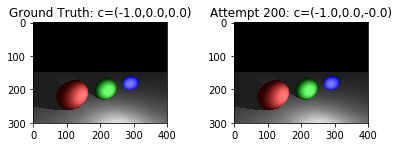

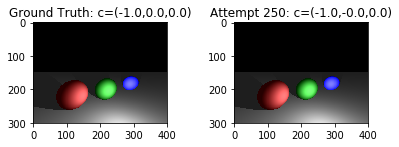

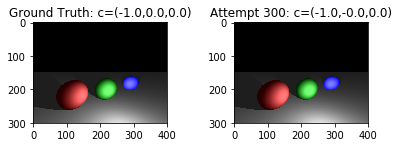

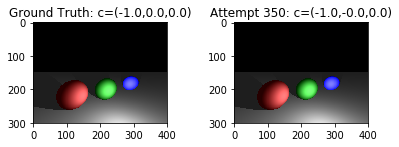

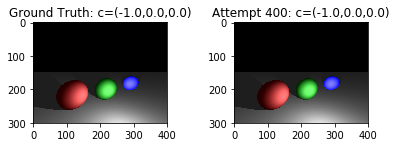

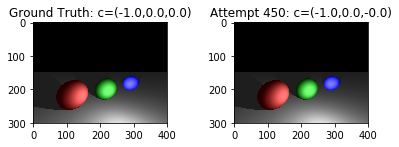

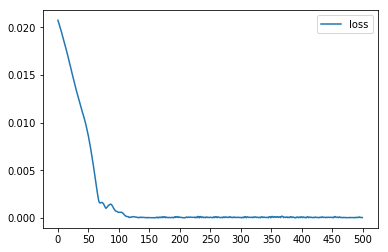

In [126]:
# Consider flat-shaded image without subsampling
#train(true_image, FlatRenderer(pred_scene), image_type='albedo')

# Consider flat-shaded image with subsampling
#train(true_image, FlatRenderer(pred_scene), subsampling=True, image_type='albedo')

# Consider phong-shaded image without subsampling
phong_renderer = PhongRenderer(pred_scene)
train(true_phong_image, phong_renderer, image_type='albedo')


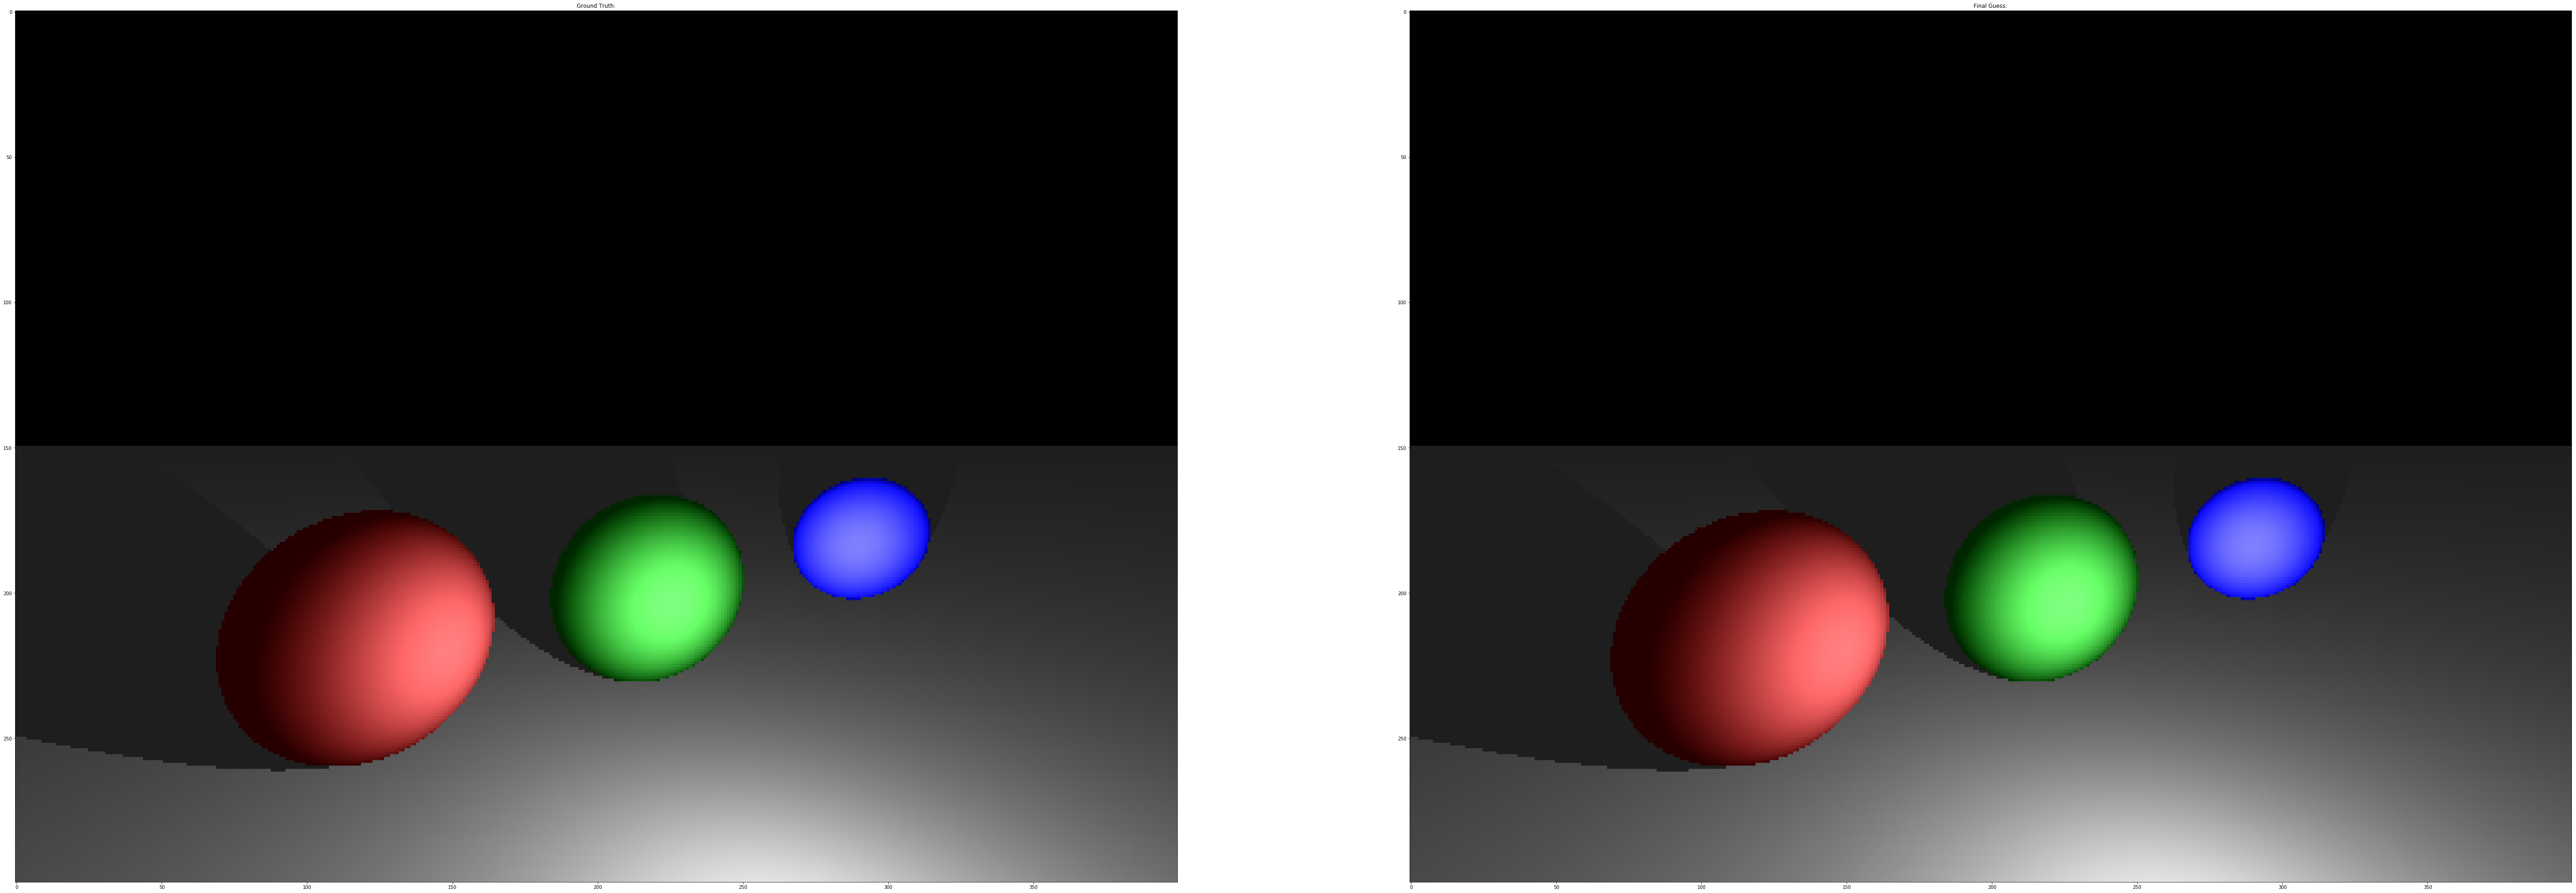

In [127]:
plt.figure(figsize=(100,100))
true_phong_image.show_image('albedo', title='Ground Truth:', subplot='121')
phong_renderer.forward().show_image('albedo', title='Final Guess:', subplot='122')
plt.show()